# Import the required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

# Download the Oxford-IIIT Pets dataset
The dataset is [available from TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet). The segmentation masks are included in version 3+.




In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [3]:
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

In addition, the image color values are normalized to the `[0,1]` range. Finally, as mentioned above the pixels in the segmentation mask are labeled either {1, 2, 3}. For the sake of convenience, subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}.

In [4]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [5]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

The dataset already contains the required training and test splits, so continue to use the same splits.




In [6]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [7]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

The following class performs a simple augmentation by randomly-flipping an image.

In [8]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

Build the input pipeline, applying the Augmentation after batching the inputs.

In [9]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

validation_batches = test_images.take(3000).batch(BATCH_SIZE)
test_batches = test_images.skip(3000).take(669).batch(BATCH_SIZE)

Visualize an image example and its corresponding mask from the dataset.

In [10]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

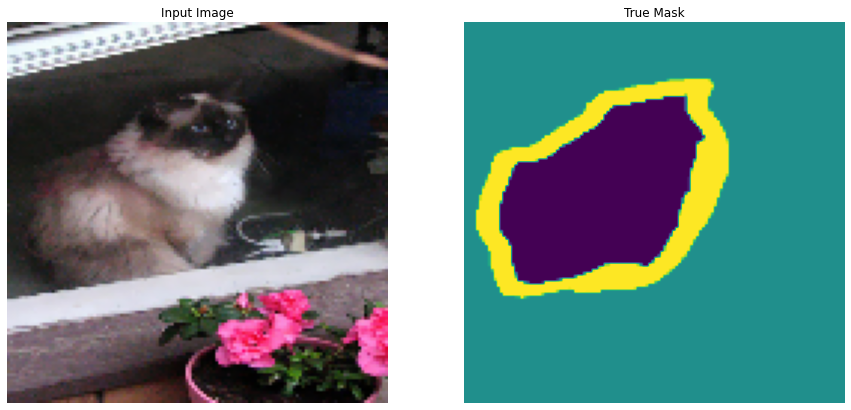

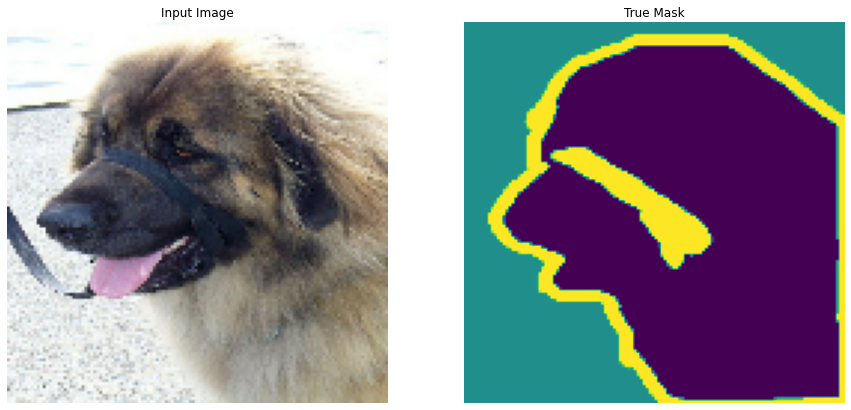

In [11]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

# Model Architecture
Now that we have the data ready for training, let's define the U-Net model architecture. As mentioned earlier, the U-Net is shaped like a letter U with an encoder, decoder, and the skip connections between them. So we will create a few building blocks to make the U-Net model.
## Building blocks
First, we creat a function `double_conv_block` with layers `Conv2D-RELU-Conv2D-RELU`, which we will use in both the encoder (or the contracting path) and the bottleneck of the U-Net.

In [12]:
def double_conv_block(x, n_filters):
  # Conv2D then RELU activation
  x = keras.layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
  # Conv2D then RELU activation
  x = keras.layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
  return x

Then we define a `downsample_block` function for downsampling or feature extraction to be used in the encoder.

In [13]:
def downsample_block(x, n_filters):
  f = double_conv_block(x, n_filters)
  p = keras.layers.MaxPooling2D(2)(f)
  p = keras.layers.Dropout(0.3)(p)
  return f, p

Finally, we define an upsampling function `upsample_block` for the decoder (or expanding path) of the U-Net.

In [14]:
def upsample_block(x, conv_features, n_filters):
  # Upsample
  x = keras.layers.Conv2DTranspose(n_filters, 3, 2, padding='same')(x)
  # Concatenate
  x = keras.layers.Concatenate()([x, conv_features])
  # Dropout
  x = keras.layers.Dropout(0.3)(x)
  # Conv2D tiwce with RELU activation
  x = double_conv_block(x, n_filters)
  return x

# U-Net Model
First, we create a `build_unet_model` function, specify the inputs, encoder layers, bottleneck, decoder layers, and finally the output layer with `Conv2D` with activation of `softmax`. Note the input image shape is `128*128*3`. The output has three channels corresponding to the three classes that the model will classify each pixel for: background, foreground object, and object outline.

In [15]:
def build_unet_model():
  # inputs
  inputs = keras.layers.Input(shape=(128, 128, 3))
  # encoder: contracting path downsample
  # 1 - downsample
  f1, p1 = downsample_block(inputs, 64)
  # 2 - downsample
  f2, p2 = downsample_block(p1, 128)
  # 3 - downsample
  f3, p3 = downsample_block(p2, 256)
  # 4 - downsample
  f4, p4 = downsample_block(p3, 512)
  # 5 - bottleneck
  bottleneck = double_conv_block(p4, 1024)
  # decoder: expanding path - upsample
  # 6 - upsample
  u6 = upsample_block(bottleneck, f4, 512)
  # 7 - upsample
  u7 = upsample_block(u6, f3, 256)
  # 8 - upsample
  u8 = upsample_block(u7, f2, 128)
  # 9 - upsample
  u9 = upsample_block(u8, f1, 64)
  # outputs
  outputs = keras.layers.Conv2D(3, 1, padding='same', activation='softmax')(u9)
  # unet model with Keras Functional API
  unet_model = tf.keras.Model(inputs, outputs, name='U-Net')
  return unet_model

We call the `build_unet_model` function to create the model `unet_model`:

In [16]:
unet_model = build_unet_model()

And we can visualize the model architecture with `model.summary()` to see each detail of the model.

In [17]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

And we can use a Keras utils function called `plot_model` to generate a more visual diagram, including the skip connections.

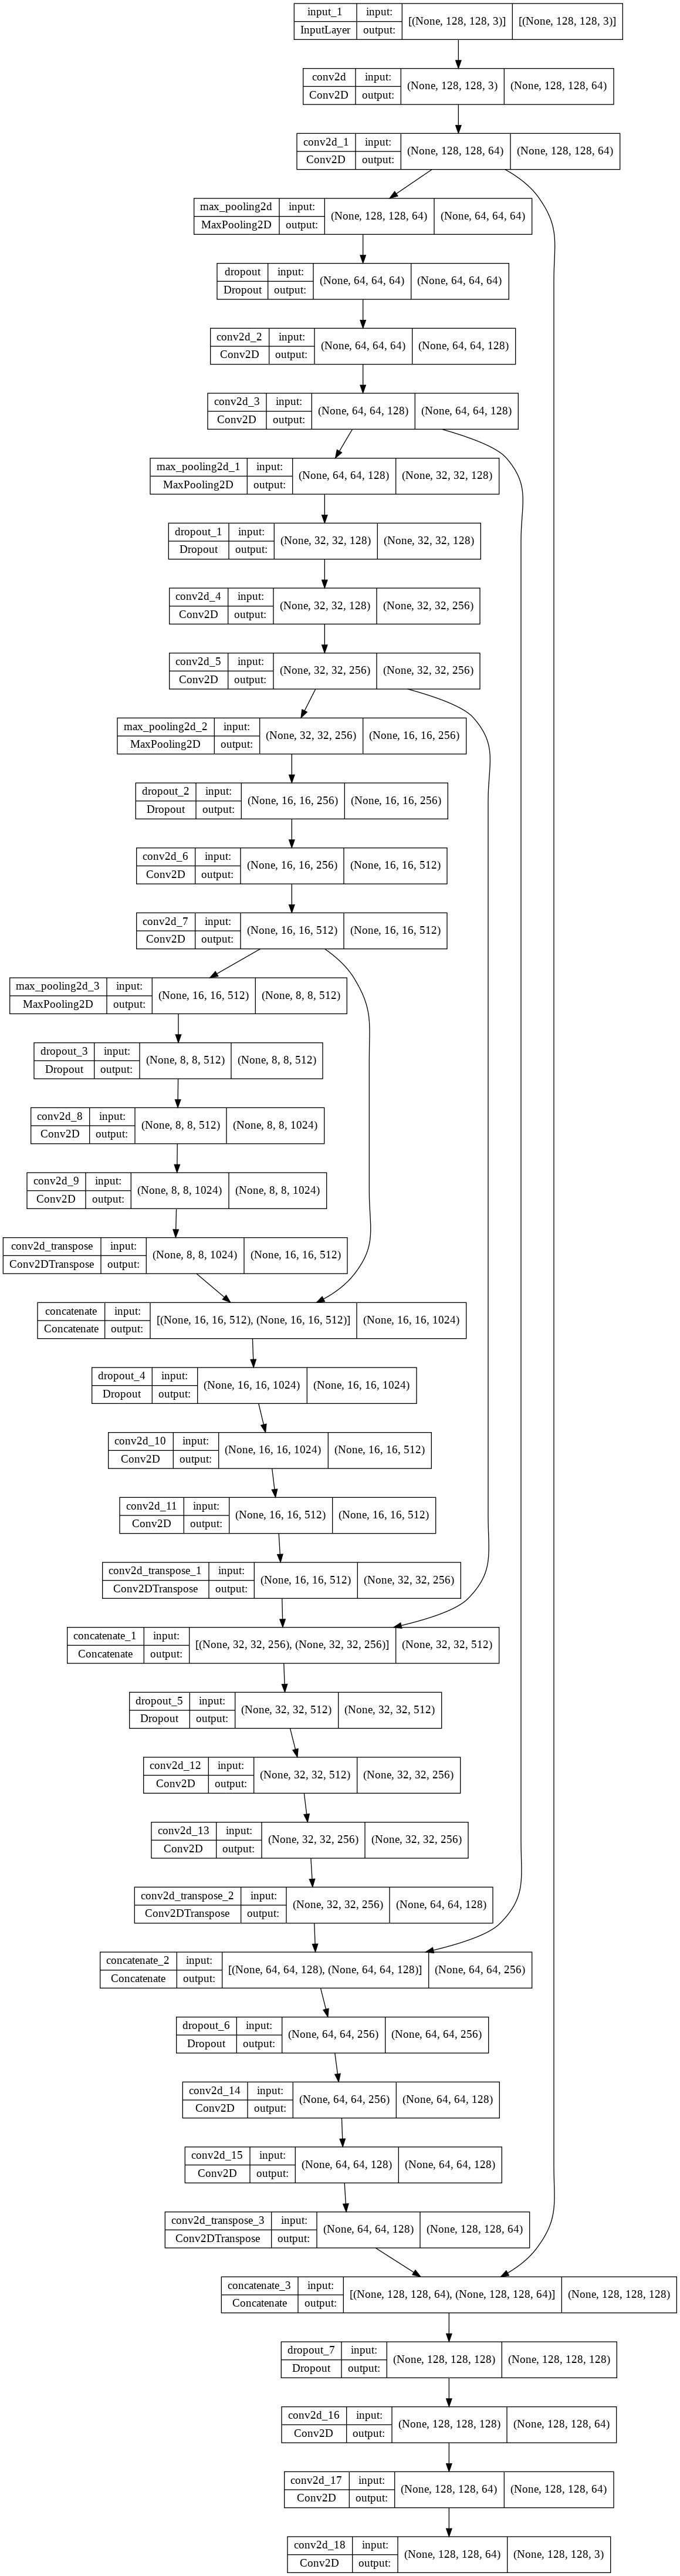

In [18]:
tf.keras.utils.plot_model(unet_model, show_shapes=True)

# Compile and Train U-Net
To compile `unet_model`, we specify the optimizer, the loss function, and the accuracy metrics to track during training:

In [19]:
unet_model.compile(optimizer='adam',
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                   metrics=["accuracy"])

We train the `unet_model` by calling `model.fit()` and training it for 20 epochs.

In [20]:
NUM_EPOCHS = 20

VAL_SUBSPLITS = 5
TEST_LENGTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENGTH // BATCH_SIZE // VAL_SUBSPLITS

history = unet_model.fit(train_batches,
                         epochs=NUM_EPOCHS,
                         steps_per_epoch=STEPS_PER_EPOCH,
                         validation_steps=VALIDATION_STEPS,
                         validation_data=validation_batches)

Epoch 1/20
57/57 [==============================] - 83s 990ms/step - loss: 0.8968 - accuracy: 0.5718 - val_loss: 0.8052 - val_accuracy: 0.5808
Epoch 2/20
57/57 [==============================] - 64s 984ms/step - loss: 0.7608 - accuracy: 0.6426 - val_loss: 0.6807 - val_accuracy: 0.7082
Epoch 3/20
57/57 [==============================] - 56s 979ms/step - loss: 0.6246 - accuracy: 0.7380 - val_loss: 0.5782 - val_accuracy: 0.7663
Epoch 4/20
57/57 [==============================] - 56s 978ms/step - loss: 0.5600 - accuracy: 0.7694 - val_loss: 0.5205 - val_accuracy: 0.7882
Epoch 5/20
57/57 [==============================] - 56s 979ms/step - loss: 0.5150 - accuracy: 0.7875 - val_loss: 0.4661 - val_accuracy: 0.8090
Epoch 6/20
57/57 [==============================] - 56s 981ms/step - loss: 0.4700 - accuracy: 0.8073 - val_loss: 0.4569 - val_accuracy: 0.8100
Epoch 7/20
57/57 [==============================] - 56s 981ms/step - loss: 0.4434 - accuracy: 0.8192 - val_loss: 0.4092 - val_accuracy: 0.8342

# Learning curve from model history
After training for 20 epochs, we get a training accuracy and a validation accuracy of `~0.88`. The learning curve during training indicates that the model is doing well on both the training dataset and validation set, which indicates the model is generalizing well without much overfitting.

In [21]:
def display_learning_curves(history):
  acc = history.history["accuracy"]
  val_acc = history.history["val_accuracy"]

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  epochs_range = range(NUM_EPOCHS)
  fig = plt.figure(figsize=(12, 6))

  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label="train accuracy")
  plt.plot(epochs_range, val_acc, label="validation accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend(loc="lower right")

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label="train loss")
  plt.plot(epochs_range, val_loss, label="validation loss")
  plt.title("Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc="upper right")

  fig.tight_layout()
  plt.show()

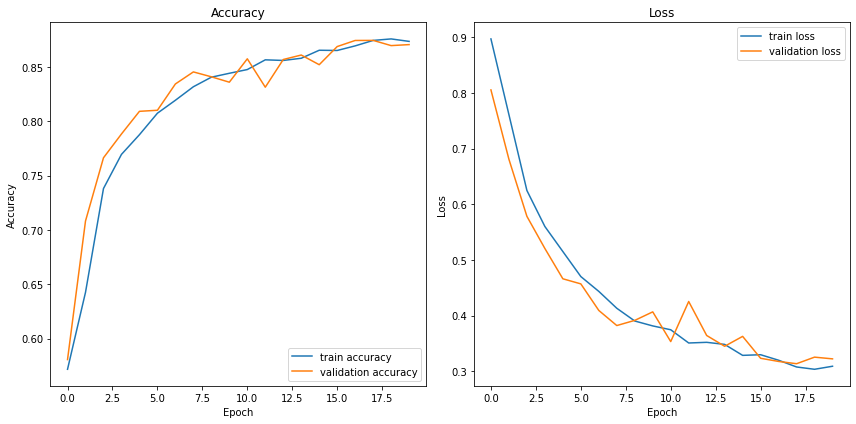

In [22]:
# Display learning curves
display_learning_curves(history)

# Prediction
Now that we have completed training the `unet_model`, let's use it to make predictions on a few sample images of the test dataset.

In [23]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [24]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = unet_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])

In [25]:
count = 0
for i in test_batches:
  count += 1
print("number of batches:", count)

number of batches: 11


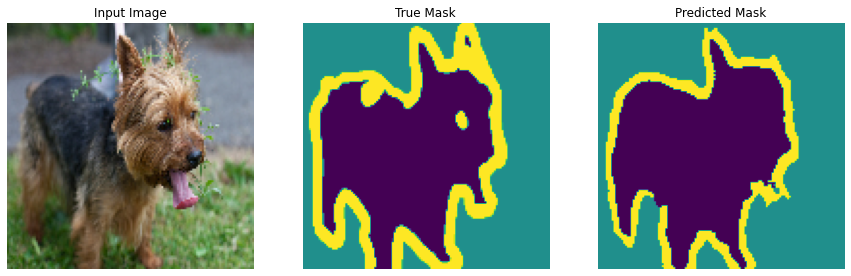

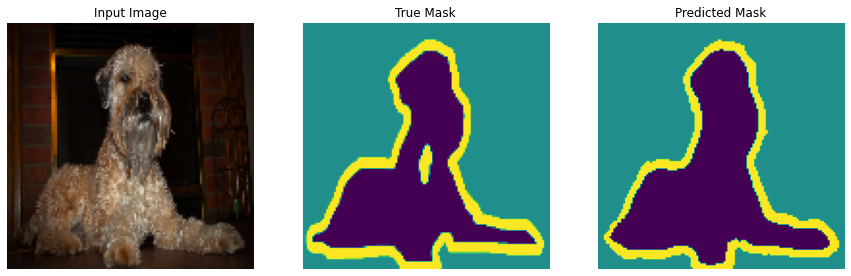

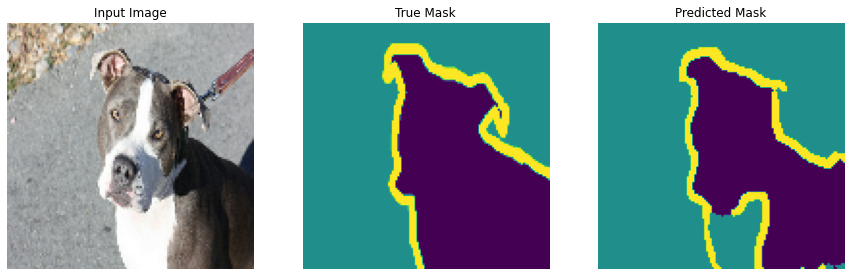

In [26]:
show_predictions(test_batches.skip(5), 3)